# Split-Operator Fourier Transform (SOFT) Code

This code can be used for wavefunction propagation in both real (i.e. quantum dynamics) and imaginary (i.e. state purification) time.

The following modules are necessary for calculation:
- numpy
- scipy
- time

The following modules are necessary for data handling:
- os

The following modules are necessary for image processing and display:
- matplotlib
- imageio
- natsort
- IPython

In [88]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import os
import imageio.v2 as imageio
from natsort import natsorted
from IPython.display import Image

The dictionaries params, wf_params, and save_params are used to define the simulation and output parameters.

In [106]:
params = {'nstate':0, 'mass':1.0, 'xmin':-2.0, 'xmax':5.0, 'npoints':2048, 
          'model':'morse', 'outFreq':100, 'dt':0.001, 'maxIter':2000, 
          'calcType':'TDSE', 'listOfProps':['Energy','Norm']}
wf_params = {'x0':0.5, 'p0':0.0, 'a0':2.5, 's0':0.0, 'n0':1}
save_params = {'dataDir':'1D_oscillator', 'parentDir':'.'}

The potential function takes as an argument an array of position values and returns a desired potential.

**potential** (*x*)
- *x (array)* : Input array of position points
- *v (array)* : Output array of potential values v(x)

In [107]:
def potential(x):
#    v = 0.5*x*x
#    v = 0.2*x**4-x**2+1.25
    v=10.0*(1.0-np.exp(-1.0*(x-0.0)))**2
    return v

The split-operator function takes as arguments the previous step's wavefunction, position and momentum vectors, potential, lower-state wavefunctions, the current state to be calculated, and the calculation type. It returns the current iteration's wavefunction array.

**soft** (*wf, x, p, v, wfs, state, calcType*)
- *wf (array)* : wavefunction array from the previous iteration
- *x (array)* : position array
- *p (array)* : momentum array
- *v (array)* : potential array, as calculated from the **potential**(x) function
- *wfs (array of arrays)* : array containing arrays of lower-state wavefunctions (i.e., wf[state=0], wf[state=1], ...). This is only used when *calcType*='TISE'.
- *state (integer)* : state to be calculated. This is only used when *calcType*='TISE'.
- *calcType (string)* : calculation type; accepted values are 'TDSE' and 'TISE' for real- and imaginary-time propagation, respectively.

In [108]:
def soft(wf, x, p, v, wfs, state, calcType):

#Compute part of the scaling factor sqrt(oldNorm/norm) for ITP calculations, if necessary.
    if calcType == 'TISE':
        oldNorm = np.trapz(np.conj(wf)*wf, x)

#Define the momentum-space kinetic energy operator KE = p^2/2m.        
    ke = 0.5*p*p*invM
    
#Perform the first potential half-step of the propagation in real-space.
    wf = np.exp(-0.5*v*dt)*wf

#Fourier transform into momentum-space (and back) to compute the kinetic full-step.
    wf = sp.fft.fft(wf)
    wf = np.exp(-ke*dt)*wf
    wf = sp.fft.ifft(wf)
    
#Perform the second potential half-step of the propagation in real-space.
    wf = np.exp(-0.5*v*dt)*wf

#Project out lower states if computing excited states in the ITP formalism.
    if calcType == 'TISE':
        if state > 0:
            for state2 in range(0,state):
                wfProj = wfs[state2]
                proj = np.trapz(np.conj(wfProj)*wf,x)*wfProj
                wf = wf - proj

#Renormalize in the ITP formalism to preserve probability density (psi^2 = 1).
        norm = np.trapz(np.conj(wf)*wf, x)
        wf = wf*np.sqrt(oldNorm/norm)
        
    return wf

The properties function takes as arguments the wavefunction, position, momentum, and potential arrays, as well as a list of desired properties to be calculated. Currently both energy and norm are calculated and returned.

**properties** (*wf, x, p, v, listOfProps*)
- *wf (array)* : wavefunction array from the previous iteration
- *x (array)* : position array
- *p (array)* : momentum array
- *v (array)* : potential array, as calculated from the **potential**(x) function
- *listOfProps (list of strings)* : list of properties to be calculated (currently restricted to norm and energy)

In [109]:
def properties(wf,x,p,v,listOfProps):
#Initialize the list of properties, energy, and norm quantities.
    listOfProps = [prop.lower() for prop in listOfProps]
    cwf = np.conj(wf)
    energy, norm = 0.0, 0.0

#Check if the norm needs to be computed, and do it as necessary.
    if 'norm' in listOfProps:
        norm = np.trapz(cwf*wf, x)
        normCheck = True

#Check if the energy needs to be computed, and do it as necessary.
    if 'energy' in listOfProps:
        pe = v*wf
        ke = 0.5*invM*sp.fft.ifft(p*p*sp.fft.fft(wf))
        
#Perform a norm calculation if needed, as energy requires it.
        if normCheck:
            energy = np.trapz(cwf*(ke+pe), x)/norm
        else:
            norm = np.trapz(cwf*wf, x)
            energy = np.trapz(cwf*(ke+pe), x)/norm

    return energy.real, norm.real

The initialize function takes as arguments the boundaries on position space, the number of points needed to discretize the space, and the parameters needed to create the initial wavefunction. It returns the initial wavefunction and the position- and momentum-space arrays.

**initialize** (*xmin, xmax, npoints, wf_params*)
- *xmin (float)* : minimum boundary on position space
- *xmax (float)* : maximum boundary on position space
- *npoints (integer)* : number of points used to discretize space (ideal to use a power of two)
- *wf_params (dictionary)* : dictionary of wavefunction parameters needed to specify the initial wavefunction

In [110]:
def initialize(xmin,xmax,npoints,wf_params):
#Establish the position and momentum grids; the scaling on the momentum grid is an artifact of 
#how numpy handles fftfreq point spacing.
    grid, dx = np.linspace(xmin,xmax,npoints,retstep=True)
    pgrid = sp.fft.fftfreq(npoints,d=dx/(2.0*np.pi))

#Extract the wavefunction parameters from the wf_params dictionary.
    x0 = wf_params['x0']; a0 = wf_params['a0']
    p0 = wf_params['p0']; s0 = wf_params['s0']
    
#Generate the initial wavefunction.
    #wf = np.sqrt(2/length)*np.sin(nstate*np.pi*grid/length)
    alpha = (a0/np.pi)**0.25
    wf = alpha*np.exp(-0.5*a0*(grid-x0)**2+p0*(grid-x0)*1.0j+s0*1.0j)
    
    print(f'Grid spacing with {npoints} points is: {dx:6f}')
    
    return wf, grid, pgrid

The propagation loop utilizes the above functions to calculate time-dependent and time-independent (as chosen) wavefunctions and properties.

In [111]:
#Create and manipulate some folders for data storage.
dataDir = save_params['dataDir']
parentDir = "/Users/mdutra/Documents/PCHEM_TOOLS"
path = os.path.join(parentDir, dataDir)

if not os.path.exists(path):
    os.mkdir(path)
    os.mkdir(path+'/animation')
    print("Data directory set to: ", path)
    print()
    
#Open the overall data file for logging.
dataFile = open(str(path)+'/data.out','w')

#Display the chosen parameters.
for key in params:
    print(f'{key} = {params[key]}')
print()

for key in wf_params:
    print(f'{key} = {wf_params[key]}')
print()

#Store the parameters locally for convenience.
invM = 1.0/params['mass']; maxIter = params['maxIter']
xmin = params['xmin']; xmax = params['xmax']; npoints = params['npoints']
outFreq = params['outFreq']; calcType = params['calcType'].upper()

if calcType == 'TISE':
    nstate = params['nstate']
    dt = params['dt']
elif calcType == 'TDSE':
    nstate = 0
    dt = params['dt']*1.0j
    
#Start the timer.
startTime = time.perf_counter()

#Initialize the wavefunction, position, momentum, and potential arrays.
wf, x, p = initialize(xmin,xmax,npoints,wf_params)
v = potential(x)

#Calculate the iteration 0 observables and store them.
energy, norm = properties(wf, x, p, v, ['Energy','Norm'])
print(f'Iteration = {0}  Energy = {energy:6f}  Norm = {norm:6f}')
dataFile.write(f'{0} {energy:6f} {norm:6f}\n')
        
snapshotFile = open(str(path)+'/snapshot0.txt','w')
np.savetxt(snapshotFile,[x,wf,v])
snapshotFile.close()

#Main calculation loop(s); loop over states and iterations.
wfs = []
for state in range(0,nstate+1):
    for step in range(0,maxIter):
        wf = soft(wf, x, p, v, wfs, state, calcType)
        
        if int(step+1) % outFreq == 0 and state == nstate:
            energy, norm = properties(wf, x, p, v, ['Energy','Norm'])
            print(f'Iteration = {step+1}  Energy = {energy:6f}  Norm = {norm:6f}')
            dataFile.write(f'{step+1} {energy:6f} {norm:6f}\n')
            
            snapshotFile = open(str(path)+'/snapshot'+str(step+1)+'.txt','w')
            np.savetxt(snapshotFile,[x,wf,v])
            snapshotFile.close() 
            
    wfs.append(wf)
dataFile.close()

#Print timing data.
stopTime = time.perf_counter()
print("Performace: ", round(stopTime - startTime,2), " seconds")

nstate = 0
mass = 1.0
xmin = -2.0
xmax = 5.0
npoints = 2048
model = morse
outFreq = 100
dt = 0.001
maxIter = 2000
calcType = TDSE
listOfProps = ['Energy', 'Norm']

x0 = 0.5
p0 = 0.0
a0 = 2.5
s0 = 0.0
n0 = 1

Grid spacing with 2048 points is: 0.003420
Iteration = 0  Energy = 2.706722  Norm = 1.000000
Iteration = 100  Energy = 2.706751  Norm = 1.000000
Iteration = 200  Energy = 2.706751  Norm = 1.000000
Iteration = 300  Energy = 2.706803  Norm = 1.000000
Iteration = 400  Energy = 2.709841  Norm = 1.000000
Iteration = 500  Energy = 2.726324  Norm = 1.000000
Iteration = 600  Energy = 2.747050  Norm = 1.000000
Iteration = 700  Energy = 2.783756  Norm = 1.000000
Iteration = 800  Energy = 2.832591  Norm = 1.000000
Iteration = 900  Energy = 2.899768  Norm = 1.000000
Iteration = 1000  Energy = 2.888665  Norm = 1.000000
Iteration = 1100  Energy = 2.929531  Norm = 1.000000
Iteration = 1200  Energy = 2.982276  Norm = 1.000000
Iteration = 1300  Energy = 2.989979  Norm = 1.000000
Iteration = 1400  E

In [112]:
animationDir = path+'/animation'
for fileName in sorted(os.listdir(path)):
    if fileName.endswith('.txt'):
#        data = open(path+'/'+fileName,'r')
        data = np.loadtxt(path+'/'+fileName,dtype=complex)
        x,wf,v = data[0], data[1], data[2]
        fig, ax = plt.subplots( nrows=1, ncols=1 )
        plt.xlim(-2,2); plt.ylim(0,2)
        ax.plot(x,np.conj(wf)*wf)
        ax.plot(x,v)
        
        imgName = fileName[:-4]
        fig.savefig(animationDir+'/'+imgName+'.png')
        plt.close()

images = []
for file_name in natsorted(os.listdir(animationDir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(animationDir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
#for _ in range(10):
#    images.append(imageio.imread(file_path))

imageio.mimsave(animationDir+'/movie.gif', images)

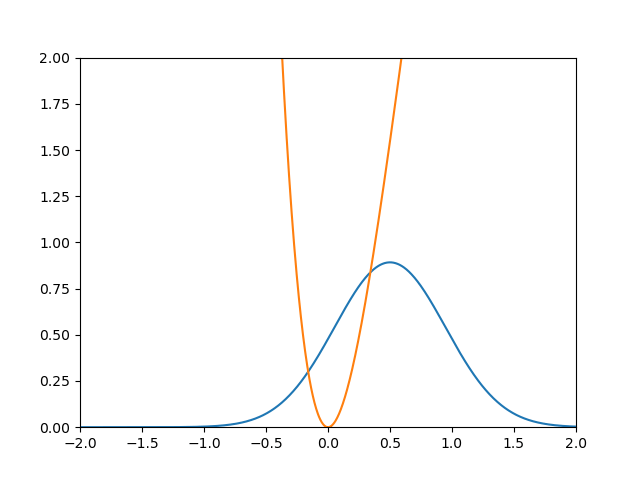

In [113]:
display(Image(data=open(animationDir+'/movie.gif','rb').read(), format='png'))

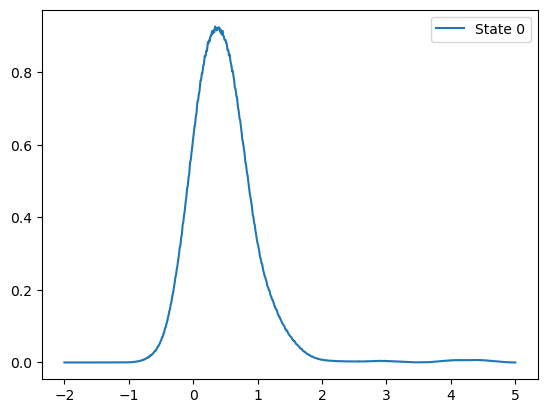

In [114]:
labels = []
for n in range(params['nstate']+1):
    plt.plot(x,np.conj(wfs[n])*wfs[n])
    labels.append("State " + str(n))
plt.legend(labels)
plt.show()

In [ ]:
def PotentialClass:
    def ho(a,b):
        v = a*x*x+b
        return v
    def doubleWell(a,b,c):
        v = a*x**4+b*x**2+c
        return v